In [1]:
import rpSBML
import rpGraph
import rpDraw
import matplotlib.pyplot as plt
import networkx as nx
import logging
from rdkit.Chem import MolFromInchi
from rdkit.Chem import Draw
import copy
import json
import re
import drawSvg as draw
import svgutils.transform as sg

In [2]:
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)
logging.basicConfig(level=logging.NOTSET)

logging.basicConfig(
    level=logging.DEBUG,
    #level=logging.WARNING,
    #level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(levelname)s %(module)s - %(funcName)s: %(message)s',
    datefmt='%d-%m-%Y %H:%M:%S',
)

In [3]:
#root_path = '/home/mdulac/Downloads/'
root_path = '/Users/melchior/Downloads/'

#rpsbml = rpSBML.rpSBML('test', path='rp_1_3.sbml.xml')
#BUG BUG in the ordering of reactions
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_3_8.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_18_1.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_16_1.sbml.xml')

#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy225-[Ranked_Pathways]/rp_1_3.sbml.xml')

rpsbml = rpSBML.rpSBML('test', path=root_path+'rpglobalscore_101/rp_5_4.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path='/home/mdulac/Downloads/rpglobalscore_104/rp_5_1.sbml.xml')

rpgraph = rpGraph.rpGraph(rpsbml)
rpdraw = rpDraw.rpDraw()
target = [i for i in list(rpgraph.G.nodes) if 'TARGET' in i][0]

DEBUG:rpSBML:Started instance of rpSBML
DEBUG:rpGraph:Started instance of rpGraph


In [4]:
arrowhead = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient='auto', id='normal_arrow')
arrowhead.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
arrowhead_flat = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient=0, id='flat_arrow')
arrowhead_flat.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
rev_arrowhead = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient=0, id='rev_flat_arrow')
rev_arrowhead.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
arrowhead_comp_x = 7.0
arrowhead_comp_y = 7.0

In [5]:
def drawChemicalList(id_inchi, subplot_size=[200, 200]):
    toRet = {}
    inchi_list = list(set([id_inchi[i] for i in id_inchi]))
    list_mol = [MolFromInchi(inchi) for inchi in inchi_list]
    for i in range(len(list_mol)):
        cp_list_mol = copy.deepcopy(list_mol)
        cp_list_mol.pop(i)
        tmp_list_mol = [list_mol[i]]+cp_list_mol
        img = Draw.MolsToGridImage(tmp_list_mol, molsPerRow=1, subImgSize=(subplot_size[0], subplot_size[1]), useSVG=True)
        #add the groups tag with the id's of the reactions -- should have be size width=subplot_size[0] height=subplot_size[1]*len(list_mol)
        bond_0_count = 0
        svg_str = ''
        for line in img.splitlines():
            add_line = True
            m0 = re.findall("(\d+\.\d+)", line)
            if m0:
                for y in m0:
                    if float(y)>subplot_size[1]:
                        add_line = False
            m1 = re.findall("height=\'\d+", line)
            if m1:
                line = re.sub(r"height=\'\d+", "height=\'"+str(subplot_size[1]), line)
                #line.replace(str(subplot_size[i]*len(list_mol)), str(subplot_size[1]))
            if add_line:
                svg_str += line+'\n'
        for y in id_inchi:
            if id_inchi[y]==inchi_list[i]:
                toRet[y] = svg_str
    return toRet

In [134]:
def graph_svg(G,
              target,
              subplot_size=[200,200],
              reac_size=[20,60],
              reac_fill_color='#ddd',
              reac_stroke_color='black',
              reac_stroke_width=2,
              arrow_gap_size=100,
              arrow_stroke_color='black',
              arrow_stroke_width=2,
              plot_only_central=False,
              filter_cofactors=True,
              filter_sink_species=True):
    #gather all the inchis and convert to svg
    resG, pos = rpdraw._hierarchy_pos(G, 
                                      target, 
                                      plot_only_central=plot_only_central, 
                                      filter_cofactors=filter_cofactors,
                                      filter_sink_species=filter_sink_species)
    print(pos)
    id_inchi = {}
    for node in list(resG.nodes):
        if resG.node.get(node)['type']=='species':
            print(node)
            print(resG.node.get(node))
            id_inchi[node] = resG.node.get(node)['brsynth']['inchi']
    id_svg = drawChemicalList(id_inchi, subplot_size)
    #first stack the 
    print('============================')
    pathway_layers = []
    ordered_y = sorted(list(set([pos[i][1] for i in pos])))
    for layer_y_loc in ordered_y:
        ordered_x = sorted(list(set([pos[i][0] for i in pos if pos[i][1]==layer_y_loc])))
        reaction = []
        for layer_x_loc in ordered_x:
            for node_id in pos:
                if pos[node_id][1]==layer_y_loc and pos[node_id][0]==layer_x_loc:
                    n = resG.nodes.get(node_id)
                    reaction.append(node_id)
                    break
        pathway_layers.append(reaction)
    print('pathway_layers: '+str(pathway_layers))
    print('============================')
    x_len = subplot_size[0]*len(pathway_layers)
    len_max_y = max([len(i) for i in pathway_layers])
    y_len = subplot_size[1]*len_max_y
    #make the fig white
    fig = sg.SVGFigure(str(x_len), str(y_len))
    #add a white background to the full image
    background = draw.Drawing(x_len, y_len, origin=(0,0))
    """
    d = draw.Drawing(x_len, y_len, origin=(0,0))
    d.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(d.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    """
    #######################
    x_move = 0
    print('############ Chem/Reac ###############')
    print('len_max_y: '+str(len_max_y))
    print('x_len: '+str(x_len))
    print('y_len: '+str(y_len))
    nodes_attach_locs = {}
    for layer in pathway_layers:
        y_move = 0
        y_shift = (y_len-subplot_size[1]*len(layer))/2
        print('====== y_shift: '+str(y_shift)+' =====')
        for cid in layer:
            node = G.node.get(cid)
            if node['type']=='species':
                print('\tSpecies: '+str(cid))
                print('\tx: '+str(x_move))
                print('\ty: '+str(y_move+y_shift))
                print('\tleft: '+str((x_move, y_len/len(layer)/2)))
                print('\tright: '+str((x_move+subplot_size[0], y_len/len(layer)/2)))
                print('\t-------------------------------')
                f = sg.fromstring(id_svg[cid])
                p = f.getroot()
                p.moveto(x_move, y_move+y_shift)
                fig.append(p)
                nodes_attach_locs[cid] = {'left': (x_move, y_len/len(layer)/2), 
                                          'right': (x_move+subplot_size[0], y_len/len(layer)/2)}
            if node['type']=='reaction':
                #draw the reaction rectangle
                print('\tReaction: '+str(cid))
                d = draw.Drawing(subplot_size[0], subplot_size[1], origin=(0,0))
                d.append(draw.Rectangle(0, 0, subplot_size[0], subplot_size[1], fill='#FFFFFF'))
                #add white backgroung TODO perhaps add blurry
                reac_x = subplot_size[0]/2-reac_size[0]*len_max_y/2
                print('\tx: '+str(reac_x))
                reac_y = subplot_size[1]/2-reac_size[1]/2
                print('\ty: '+str(reac_y))
                edge_x = subplot_size[0]/2-reac_size[1]/2                
                edge_y = subplot_size[1]/2-reac_size[0]/2
                print('\tedge_x: '+str(edge_x))
                print('\tedge_y: '+str(edge_y))
                print('\treac_x: '+str(reac_x))
                print('\treac_y: '+str(reac_y))
                #left = (x_move+edge_x, y_shift+reac_y)
                left = (x_move+edge_x, y_shift+subplot_size[1]/2)
                print('\tleft: '+str(left))
                #right = (x_move+edge_x+reac_size[1], y_shift+reac_y)
                right = (x_move+edge_x+reac_size[1], y_shift+subplot_size[1]/2)
                print('\tright: '+str(right))
                print('\t-------------------------------')
                d.append(draw.Rectangle(edge_x,
                                        edge_y,
                                        reac_size[1],
                                        reac_size[0],
                                        fill=reac_fill_color,
                                        stroke_width=reac_stroke_width,
                                        stroke=reac_stroke_color))
                a = sg.fromstring(d.asSvg())
                a_r = a.getroot()
                a_r.moveto(x_move, y_move+y_shift+subplot_size[1]) #WARNING: not sure why I have to + subpot
                fig.append(a_r)
                print('edge_y: '+str(edge_y))
                print('y_move: '+str(y_move))
                print('y_shift: '+str(y_shift))
                print('subplot_size[1]: '+str(subplot_size[1]))
                print(subplot_size[1]-y_shift)
                print(subplot_size[1]*len_max_y/2)
                nodes_attach_locs[cid] = {'left': left,
                                          'right': right}
                """
                nodes_attach_locs[cid] = {'left': (x_move+edge_x, 
                                                   y_move+y_shift+subplot_size[1]), 
                                          'right': (x_move+edge_x+reac_size[1], 
                                                    y_move+y_shift+subplot_size[1]+edge_y-reac_size[0]/2)}
                """
            y_move += subplot_size[1]
            #layer_num += 1
        x_move += subplot_size[0]
    print('nodes_attach_locs: '+str(nodes_attach_locs))
    ######## draw the lines #############
    print('############ Arrows ###############')
    for edge in list(resG.edges):
        print('\t---------- edge: '+str(edge)+' -----------')
        source_x = nodes_attach_locs[edge[0]]['right'][0]
        print('\tsource_x: '+str(source_x))
        source_y = nodes_attach_locs[edge[0]]['right'][1]
        print('\tsource_y: '+str(source_y))
        target_x = nodes_attach_locs[edge[1]]['left'][0]
        print('\ttarget_x: '+str(target_x))
        target_y = nodes_attach_locs[edge[1]]['left'][1]
        print('\ttarget_y: '+str(target_y))
        line_x = max([source_x, target_x])-min([source_x, target_x])
        print('\tline_x: '+str(line_x))
        line_y = max([source_y, target_y])-min([source_y, target_y])
        print('\tline_y: '+str(line_y))
        #d = draw.Drawing(x_len, y_len, origin=(0,0))
        '''
        p = draw.Path(stroke=arrow_stroke_color,
                      stroke_width=arrow_stroke_width,
                      fill='transparent',
                      marker_end=arrowhead_flat)
        p.M(source_x, source_y).C(arrow_gap_size-source_x,
                                                 source_y,
                                                 source_x,
                                                 source_y,
                                                 target_x,
                                                 target_y)
        '''
        background.append(draw.Line(source_x,
                           source_y,
                           target_x,
                           target_y,
                           stroke='red',
                           stroke_width=2,
                           fill='none',
                           marker_end=arrowhead))  # Add an arrow to the end of a line
        '''
        d.append(p)
        arrow = sg.fromstring(d.asSvg())
        a_b = arrow.getroot()
        a_b.moveto(0, line_y) #not sure why I have to move this
        fig.append(a_b)
        '''
    #background.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(background.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    svg = fig.to_str().decode("utf-8")
    open('test.svg', 'w').write(svg)

In [135]:
graph_svg(rpgraph.G, [i for i in rpgraph.G.nodes if 'TARGET' in i][0])

DEBUG:rpDraw:--------- MNXM861__64__MNXC3 ---------
DEBUG:rpDraw:{'seed': ['cpd12713'], 'sabiork': ['7867'], 'reactome': ['R-ALL-917882', 'R-ALL-917828', 'R-ALL-879326', 'R-ALL-76342'], 'metacyc': ['E-'], 'metanetx': ['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861'], 'chebi': ['10545']}
DEBUG:rpDraw:[True, True, True, True]
DEBUG:rpDraw:dict_keys(['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861', 'MNXM01', 'MNXM1', 'MNXM2', 'MNXM3', 'MNXM4', 'MNXM5', 'MNXM6', 'MNXM7', 'MNXM8', 'MNXM9', 'MNXM10', 'MNXM11', 'MNXM12', 'MNXM13', 'MNXM14', 'MNXM15', 'MNXM16', 'MNXM17', 'MNXM19', 'MNXM27', 'MNXM30', 'MNXM31', 'MNXM33', '', 'MNXM38', 'MNXM39', 'MNXM43', 'MNXM45', 'MNXM49', 'MNXM51', 'MNXM56', 'MNXM57', 'MNXM58', 'MNXM80', 'MNXM95', 'MNXM107', 'MNXM111', 'MNXM196', 'MNXM119', 'MNXM128', 'MNXM121', 'MNXM149', 'MNXM163', 'MNXM208', 'MNXM220', 'MNXM228', 'MNXM8978', 'MNXM255', 'MNXM330', 'MNXM579', 'MNXM632', 'MNXM3568', 'MNXM652', 'MNXM653', 'MNXM724', 'MNXM796', 'MNXM833', 'MNXM924', 'MNXM996', 'M

DEBUG:rpDraw:[False, False]
DEBUG:rpDraw:dict_keys(['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861', 'MNXM01', 'MNXM1', 'MNXM2', 'MNXM3', 'MNXM4', 'MNXM5', 'MNXM6', 'MNXM7', 'MNXM8', 'MNXM9', 'MNXM10', 'MNXM11', 'MNXM12', 'MNXM13', 'MNXM14', 'MNXM15', 'MNXM16', 'MNXM17', 'MNXM19', 'MNXM27', 'MNXM30', 'MNXM31', 'MNXM33', '', 'MNXM38', 'MNXM39', 'MNXM43', 'MNXM45', 'MNXM49', 'MNXM51', 'MNXM56', 'MNXM57', 'MNXM58', 'MNXM80', 'MNXM95', 'MNXM107', 'MNXM111', 'MNXM196', 'MNXM119', 'MNXM128', 'MNXM121', 'MNXM149', 'MNXM163', 'MNXM208', 'MNXM220', 'MNXM228', 'MNXM8978', 'MNXM255', 'MNXM330', 'MNXM579', 'MNXM632', 'MNXM3568', 'MNXM652', 'MNXM653', 'MNXM724', 'MNXM796', 'MNXM833', 'MNXM924', 'MNXM996', 'MNXM1191', 'MNXM1231', 'MNXM1562', 'MNXM4041', 'MNXM2255', 'MNXM3654', 'MNXM3673', 'MNXM4505', 'MNXM5928', 'MNXM40414', 'MNXM89582', 'MNXM92652', 'MNXM24', 'MNXM35', 'MNXM36', 'MNXM137', 'MNXM169', 'MNXM178', 'MNXM230', 'MNXM537', 'MNXM925', 'MNXM2229', 'MNXM8975', 'MNXM53428', 'MNXM162231'])
DEBU

DEBUG:rpDraw:MNXM13__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- RP3 ---------
DEBUG:rpDraw:--------- TARGET_0000000001__64__MNXC3 ---------
DEBUG:rpDraw:{'inchikey': ['KIDHWZJUCRJVML-UHFFFAOYSA-N'], 'seed': ['cpd12215', 'cpd00118'], 'sabiork': ['1941'], 'reactome': ['R-ALL-29610', 'R-ALL-141350'], 'metacyc': ['PUTRESCINE'], 'hmdb': ['HMDB60243', 'HMDB01414'], 'chebi': ['326268', '8650', '45092', '26405', '14972', '17148'], 'metanetx': ['MNXM89722', 'MNXM722956', 'MNXM118'], 'bigg': ['M_ptrc', 'ptrc']}
DEBUG:rpDraw:[False, False, False]
DEBUG:rpDraw:dict_keys(['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861', 'MNXM01', 'MNXM1', 'MNXM2', 'MNXM3', 'MNXM4', 'MNXM5', 'MNXM6', 'MNXM7', 'MNXM8', 'MNXM9', 'MNXM10', 'MNXM11', 'MNXM12', 'MNXM13', 'MNXM14', 'MNXM15', 'MNXM16', 'MNXM17', 'MNXM19', 'MNXM27', 'MNXM30', 'MNXM31', 'MNXM33', '', 'MNXM38', 'MNXM39', 'MNXM43', 'MNXM45', 'MNXM49', 'MNXM51', 'MNXM56', 'MNXM57', 'MNXM58', 'MNXM80', 'MNXM95', 'MNXM107', 'MNXM111', 'MNX

DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.25, 0.0), 'MNXM23__64__MNXC3': (0.75, 0.0), 'RP1': (0.25, -0.2), 'RP2': (0.75, -0.2), 'CMPD_0000000001__64__MNXC3': (0.25, -0.4), 'CMPD_0000000003__64__MNXC3': (0.75, -0.4), 'RP3': (0.5, -0.6000000000000001), 'CMPD_0000000010__64__MNXC3': (0.25, -0.8), 'MNXM161__64__MNXC3': (0.75, -0.8)}
DEBUG:rpDraw:==================================
DEBUG:rpDraw:toadd_nodes: ['MNXM89557__64__MNXC3', 'RP4']
DEBUG:rpDraw:parent_layer: ['CMPD_0000000010__64__MNXC3', 'MNXM161__64__MNXC3']
DEBUG:rpDraw:	CMPD_0000000010__64__MNXC3 --> ['RP4', 'RP3']
DEBUG:rpDraw:	Adding node: RP4
DEBUG:rpDraw:	RP4 predecessors: ['MNXM89557__64__MNXC3', 'MNXM161__64__MNXC3', 'MNXM1__64__MNXC3']
DEBUG:rpDraw:		MNXM89557__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM161__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:	MNXM161__64__MNXC3 --> ['RP4', 'RP4']
DEBUG:rpDraw:layer: ['RP4']
DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.25,

{'TARGET_0000000001__64__MNXC3': (0.25, 0.0), 'MNXM23__64__MNXC3': (0.75, 0.0), 'RP1': (0.25, -0.2), 'RP2': (0.75, -0.2), 'CMPD_0000000001__64__MNXC3': (0.25, -0.4), 'CMPD_0000000003__64__MNXC3': (0.75, -0.4), 'RP3': (0.5, -0.6000000000000001), 'CMPD_0000000010__64__MNXC3': (0.25, -0.8), 'MNXM161__64__MNXC3': (0.75, -0.8), 'RP4': (0.5, -1.0), 'MNXM89557__64__MNXC3': (0.5, -1.2)}
TARGET_0000000001__64__MNXC3
{'type': 'species', 'name': 'putrescine', 'miriam': {'inchikey': ['KIDHWZJUCRJVML-UHFFFAOYSA-N'], 'seed': ['cpd12215', 'cpd00118'], 'sabiork': ['1941'], 'reactome': ['R-ALL-29610', 'R-ALL-141350'], 'metacyc': ['PUTRESCINE'], 'hmdb': ['HMDB60243', 'HMDB01414'], 'chebi': ['326268', '8650', '45092', '26405', '14972', '17148'], 'metanetx': ['MNXM89722', 'MNXM722956', 'MNXM118'], 'bigg': ['M_ptrc', 'ptrc']}, 'brsynth': {'dfG_prime_m': {}, 'dfG_uncert': {}, 'dfG_prime_o': {}, 'smiles': '[H]N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])[H]', 'inchi': 'InChI=1S/C4H12N2/c5-3-1-2-4-

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/melchior/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


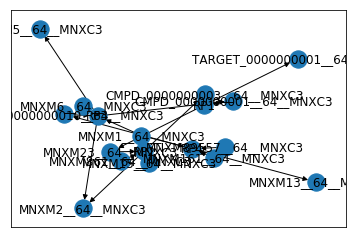

DEBUG:rpDraw:--------- MNXM861__64__MNXC3 ---------
DEBUG:rpDraw:MNXM861__64__MNXC3 is not a central species and is filtered
DEBUG:rpDraw:--------- MNXM1__64__MNXC3 ---------
DEBUG:rpDraw:MNXM1__64__MNXC3 is not a central species and is filtered
DEBUG:rpDraw:--------- MNXM89557__64__MNXC3 ---------
DEBUG:rpDraw:{'inchikey': ['WHUUTDBJXJRKMK-VKHMYHEASA-M'], 'seed': ['cpd27177', 'cpd19002', 'cpd00023'], 'sabiork': ['73', '2010'], 'reactome': ['R-ALL-428614', 'R-ALL-29404', 'R-ALL-210382', 'R-ALL-113552'], 'metacyc': ['Glutamates', 'GLT'], 'hmdb': ['HMDB60475', 'HMDB00148'], 'chebi': ['76051', '29988', '29987', '21301', '13107', '29985', '5431', '24314', '18237', '6224', '42825', '21304', '16015', '14321'], 'metanetx': ['MNXM96412', 'MNXM18', 'MNXM89557'], 'bigg': ['M_glu__L', 'glu__L']}
DEBUG:rpDraw:[False, False, False]
DEBUG:rpDraw:dict_keys(['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861', 'MNXM01', 'MNXM1', 'MNXM2', 'MNXM3', 'MNXM4', 'MNXM5', 'MNXM6', 'MNXM7', 'MNXM8', 'MNXM9', 'MNXM1

DEBUG:rpDraw:--------- MNXM15__64__MNXC3 ---------
DEBUG:rpDraw:{'inchikey': ['QGZKDVFQNNGYKY-UHFFFAOYSA-O'], 'seed': ['cpd19013', 'cpd00013'], 'sabiork': ['43', '1268'], 'reactome': ['R-ALL-76230', 'R-ALL-5693978', 'R-ALL-389843', 'R-ALL-31633', 'R-ALL-29382', 'R-ALL-2022135', 'R-ALL-140912', 'R-ALL-113561', 'R-ALL-1132163'], 'metacyc': ['AMMONIUM', 'AMMONIA'], 'hmdb': ['HMDB41827', 'HMDB00051'], 'chebi': ['29340', '29337', '7435', '49783', '22534', '28938', '7434', '44404', '44284', '44269', '22533', '13771', '13407', '13406', '13405', '16134', '135980'], 'metanetx': ['MNXM89593', 'MNXM89589', 'MNXM84', 'MNXM724015', 'MNXM723599', 'MNXM723598', 'MNXM15'], 'bigg': ['M_nh4', 'nh4', 'M_nh3', 'nh3']}
DEBUG:rpDraw:[False, False, False, False, False, False, True]
DEBUG:rpDraw:dict_keys(['MNXM96467', 'MNXM96454', 'MNXM459', 'MNXM861', 'MNXM01', 'MNXM1', 'MNXM2', 'MNXM3', 'MNXM4', 'MNXM5', 'MNXM6', 'MNXM7', 'MNXM8', 'MNXM9', 'MNXM10', 'MNXM11', 'MNXM12', 'MNXM13', 'MNXM14', 'MNXM15', 'MNXM16

DEBUG:rpDraw:==================================
DEBUG:rpDraw:toadd_nodes: ['MNXM89557__64__MNXC3', 'RP4']
DEBUG:rpDraw:parent_layer: ['CMPD_0000000010__64__MNXC3']
DEBUG:rpDraw:	CMPD_0000000010__64__MNXC3 --> ['RP4', 'RP3']
DEBUG:rpDraw:	Adding node: RP4
DEBUG:rpDraw:	RP4 predecessors: ['MNXM89557__64__MNXC3', 'MNXM161__64__MNXC3', 'MNXM1__64__MNXC3']
DEBUG:rpDraw:		MNXM89557__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM161__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:layer: ['RP4']
DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.25, 0.0), 'MNXM23__64__MNXC3': (0.75, 0.0), 'RP1': (0.25, -0.2), 'RP2': (0.75, -0.2), 'CMPD_0000000001__64__MNXC3': (0.25, -0.4), 'CMPD_0000000003__64__MNXC3': (0.75, -0.4), 'RP3': (0.5, -0.6000000000000001), 'CMPD_0000000010__64__MNXC3': (0.5, -0.8), 'RP4': (0.5, -1.0)}
DEBUG:rpDraw:==================================
DEBUG:rpDraw:toadd_nodes: ['MNXM89557__64__MNXC3']
DEBUG:rpDraw:parent_layer: ['RP4']
DEBUG:rpDraw:	

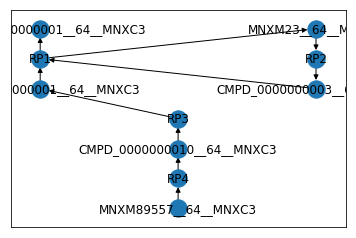

In [130]:
plot_only_central=False,
filter_cofactors=True,
filter_sink_species=True
#gather all the inchis and convert to svg
resG, pos = rpdraw._hierarchy_pos(rpgraph.G, 
                                  [i for i in rpgraph.G.nodes if 'TARGET' in i][0], 
                                  plot_only_central=plot_only_central, 
                                  filter_cofactors=filter_cofactors,
                                  filter_sink_species=filter_sink_species)
nx.draw_networkx(resG, pos=pos)

In [131]:
nx.

SyntaxError: invalid syntax (<ipython-input-131-8f89ec181897>, line 1)

In [ ]:
def graph_svg(G,
              target,
              subplot_size=[200,200],
              reac_size=[20,60],
              reac_fill_color='#ddd',
              reac_stroke_color='black',
              reac_stroke_width=2,
              arrow_gap_size=100,
              arrow_stroke_color='black',
              arrow_stroke_width=2,
              plot_only_central=False,
              filter_cofactors=True,
              filter_sink_species=True):
    #gather all the inchis and convert to svg
    resG, pos = rpdraw._hierarchy_pos(G, 
                                      target, 
                                      plot_only_central=plot_only_central, 
                                      filter_cofactors=filter_cofactors,
                                      filter_sink_species=filter_sink_species)
    id_inchi = {}
    for node in list(resG.nodes):
        if resG.node.get(node)['type']=='species':
            print(node)
            print(resG.node.get(node))
            id_inchi[node] = resG.node.get(node)['brsynth']['inchi']
    id_svg = drawChemicalList(id_inchi, subplot_size)
    print('============================')
    target_pos = pos[target]
    
    
    
    x_len = subplot_size[0]*len(pathway_layers)
    len_max_y = max([len(i) for i in pathway_layers])
    y_len = subplot_size[1]*len_max_y
    #make the fig white
    fig = sg.SVGFigure(str(x_len), str(y_len))
    #add a white background to the full image
    background = draw.Drawing(x_len, y_len, origin=(0,0))
    """
    d = draw.Drawing(x_len, y_len, origin=(0,0))
    d.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(d.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    """
    #######################
    x_move = 0
    print('############ Chem/Reac ###############')
    print('len_max_y: '+str(len_max_y))
    print('x_len: '+str(x_len))
    print('y_len: '+str(y_len))
    nodes_attach_locs = {}
    for layer in pathway_layers:
        y_move = 0
        y_shift = (y_len-subplot_size[1]*len(layer))/2
        print('====== y_shift: '+str(y_shift)+' =====')
        for cid in layer:
            node = G.node.get(cid)
            if node['type']=='species':
                print('\tSpecies: '+str(cid))
                print('\tx: '+str(x_move))
                print('\ty: '+str(y_move+y_shift))
                print('\tleft: '+str((x_move, y_len/len(layer)/2)))
                print('\tright: '+str((x_move+subplot_size[0], y_len/len(layer)/2)))
                print('\t-------------------------------')
                f = sg.fromstring(id_svg[cid])
                p = f.getroot()
                p.moveto(x_move, y_move+y_shift)
                fig.append(p)
                nodes_attach_locs[cid] = {'left': (x_move, y_len/len(layer)/2), 
                                          'right': (x_move+subplot_size[0], y_len/len(layer)/2)}
            if node['type']=='reaction':
                #draw the reaction rectangle
                print('\tReaction: '+str(cid))
                d = draw.Drawing(subplot_size[0], subplot_size[1], origin=(0,0))
                d.append(draw.Rectangle(0, 0, subplot_size[0], subplot_size[1], fill='#FFFFFF'))
                #add white backgroung TODO perhaps add blurry
                reac_x = subplot_size[0]/2-reac_size[0]*len_max_y/2
                print('\tx: '+str(reac_x))
                reac_y = subplot_size[1]/2-reac_size[1]/2
                print('\ty: '+str(reac_y))
                edge_x = subplot_size[0]/2-reac_size[1]/2                
                edge_y = subplot_size[1]/2-reac_size[0]/2
                print('\tedge_x: '+str(edge_x))
                print('\tedge_y: '+str(edge_y))
                print('\treac_x: '+str(reac_x))
                print('\treac_y: '+str(reac_y))
                #left = (x_move+edge_x, y_shift+reac_y)
                left = (x_move+edge_x, y_shift+subplot_size[1]/2)
                print('\tleft: '+str(left))
                #right = (x_move+edge_x+reac_size[1], y_shift+reac_y)
                right = (x_move+edge_x+reac_size[1], y_shift+subplot_size[1]/2)
                print('\tright: '+str(right))
                print('\t-------------------------------')
                d.append(draw.Rectangle(edge_x,
                                        edge_y,
                                        reac_size[1],
                                        reac_size[0],
                                        fill=reac_fill_color,
                                        stroke_width=reac_stroke_width,
                                        stroke=reac_stroke_color))
                a = sg.fromstring(d.asSvg())
                a_r = a.getroot()
                a_r.moveto(x_move, y_move+y_shift+subplot_size[1]) #WARNING: not sure why I have to + subpot
                fig.append(a_r)
                print('edge_y: '+str(edge_y))
                print('y_move: '+str(y_move))
                print('y_shift: '+str(y_shift))
                print('subplot_size[1]: '+str(subplot_size[1]))
                print(subplot_size[1]-y_shift)
                print(subplot_size[1]*len_max_y/2)
                nodes_attach_locs[cid] = {'left': left,
                                          'right': right}
                """
                nodes_attach_locs[cid] = {'left': (x_move+edge_x, 
                                                   y_move+y_shift+subplot_size[1]), 
                                          'right': (x_move+edge_x+reac_size[1], 
                                                    y_move+y_shift+subplot_size[1]+edge_y-reac_size[0]/2)}
                """
            y_move += subplot_size[1]
            #layer_num += 1
        x_move += subplot_size[0]
    print('nodes_attach_locs: '+str(nodes_attach_locs))
    ######## draw the lines #############
    print('############ Arrows ###############')
    for edge in list(resG.edges):
        print('\t---------- edge: '+str(edge)+' -----------')
        source_x = nodes_attach_locs[edge[0]]['right'][0]
        print('\tsource_x: '+str(source_x))
        source_y = nodes_attach_locs[edge[0]]['right'][1]
        print('\tsource_y: '+str(source_y))
        target_x = nodes_attach_locs[edge[1]]['left'][0]
        print('\ttarget_x: '+str(target_x))
        target_y = nodes_attach_locs[edge[1]]['left'][1]
        print('\ttarget_y: '+str(target_y))
        line_x = max([source_x, target_x])-min([source_x, target_x])
        print('\tline_x: '+str(line_x))
        line_y = max([source_y, target_y])-min([source_y, target_y])
        print('\tline_y: '+str(line_y))
        #d = draw.Drawing(x_len, y_len, origin=(0,0))
        '''
        p = draw.Path(stroke=arrow_stroke_color,
                      stroke_width=arrow_stroke_width,
                      fill='transparent',
                      marker_end=arrowhead_flat)
        p.M(source_x, source_y).C(arrow_gap_size-source_x,
                                                 source_y,
                                                 source_x,
                                                 source_y,
                                                 target_x,
                                                 target_y)
        '''
        background.append(draw.Line(source_x,
                           source_y,
                           target_x,
                           target_y,
                           stroke='red',
                           stroke_width=2,
                           fill='none',
                           marker_end=arrowhead))  # Add an arrow to the end of a line
        '''
        d.append(p)
        arrow = sg.fromstring(d.asSvg())
        a_b = arrow.getroot()
        a_b.moveto(0, line_y) #not sure why I have to move this
        fig.append(a_b)
        '''
    #background.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(background.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    svg = fig.to_str().decode("utf-8")
    open('test.svg', 'w').write(svg)